In [1]:
from utils.auger.fd import XYScanner
from utils import create_stream_logger
from utils import CONSTANTS
import logging

# test = XYScanner.Campaign(2024, 11)
# test.pack_files(extension = "outCorr")

13:58:06 ( +106.7s) [INFO   ] -- import logging
13:58:07 (  +390ms) [INFO   ] -- import matplotlib.pyplot as plt
13:58:07 (  +565ms) [INFO   ] -- import seaborn as so
13:58:07 (    +2ms) [INFO   ] -- import numpy as np
13:58:07 (    +5ms) [INFO   ] -- import uncertainties
13:58:07 (    +1ms) [INFO   ] -- import pandas as pd
13:58:07 (    +0ms) [WARNING] -- pandas support to be dropped at some point!
13:58:07 (    +1ms) [INFO   ] -- import binaries.tools as tools
13:58:07 (    +1ms) [INFO   ] -- set MONI_PATH = PosixPath('/home/filip/Data/monit_and_sd')
13:58:07 (    +0ms) [INFO   ] -- set HIST_PATH = PosixPath('/home/filip/Data/monit_and_sd')
13:58:07 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/home/filip/Data/plots')
13:58:07 (    +0ms) [INFO   ] -- set DATA_PATH = PosixPath('/home/filip/Data')
13:58:07 (    +0ms) [INFO   ] -- set SCAN_PATH = PosixPath('/home/filip/Public/xy-calibration')
13:58:07 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/home/filip/Public/offline/in

In [2]:
from utils.binaries import *
from utils.auger.fd import *
from utils.auger.fd.XYScanner import Telescope
from utils.plotting import *

from matplotlib import colors
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import ColorbarBase
from datetime import datetime

tel         preDAQ    preXY    XY      postXY    postDAQ
----------  --------  -------  ------  --------  ---------
2019-11-26  04513m25           04516x  4519
2022-10-21  05613m25  05614    05616x  05619     05629m25
2023-10-13  6018m25   6019     6020x   6023
2023-11-09            6068     6070    6071      6072m25
2024-11-21  6511m25   6521     6522    6523      6524m25


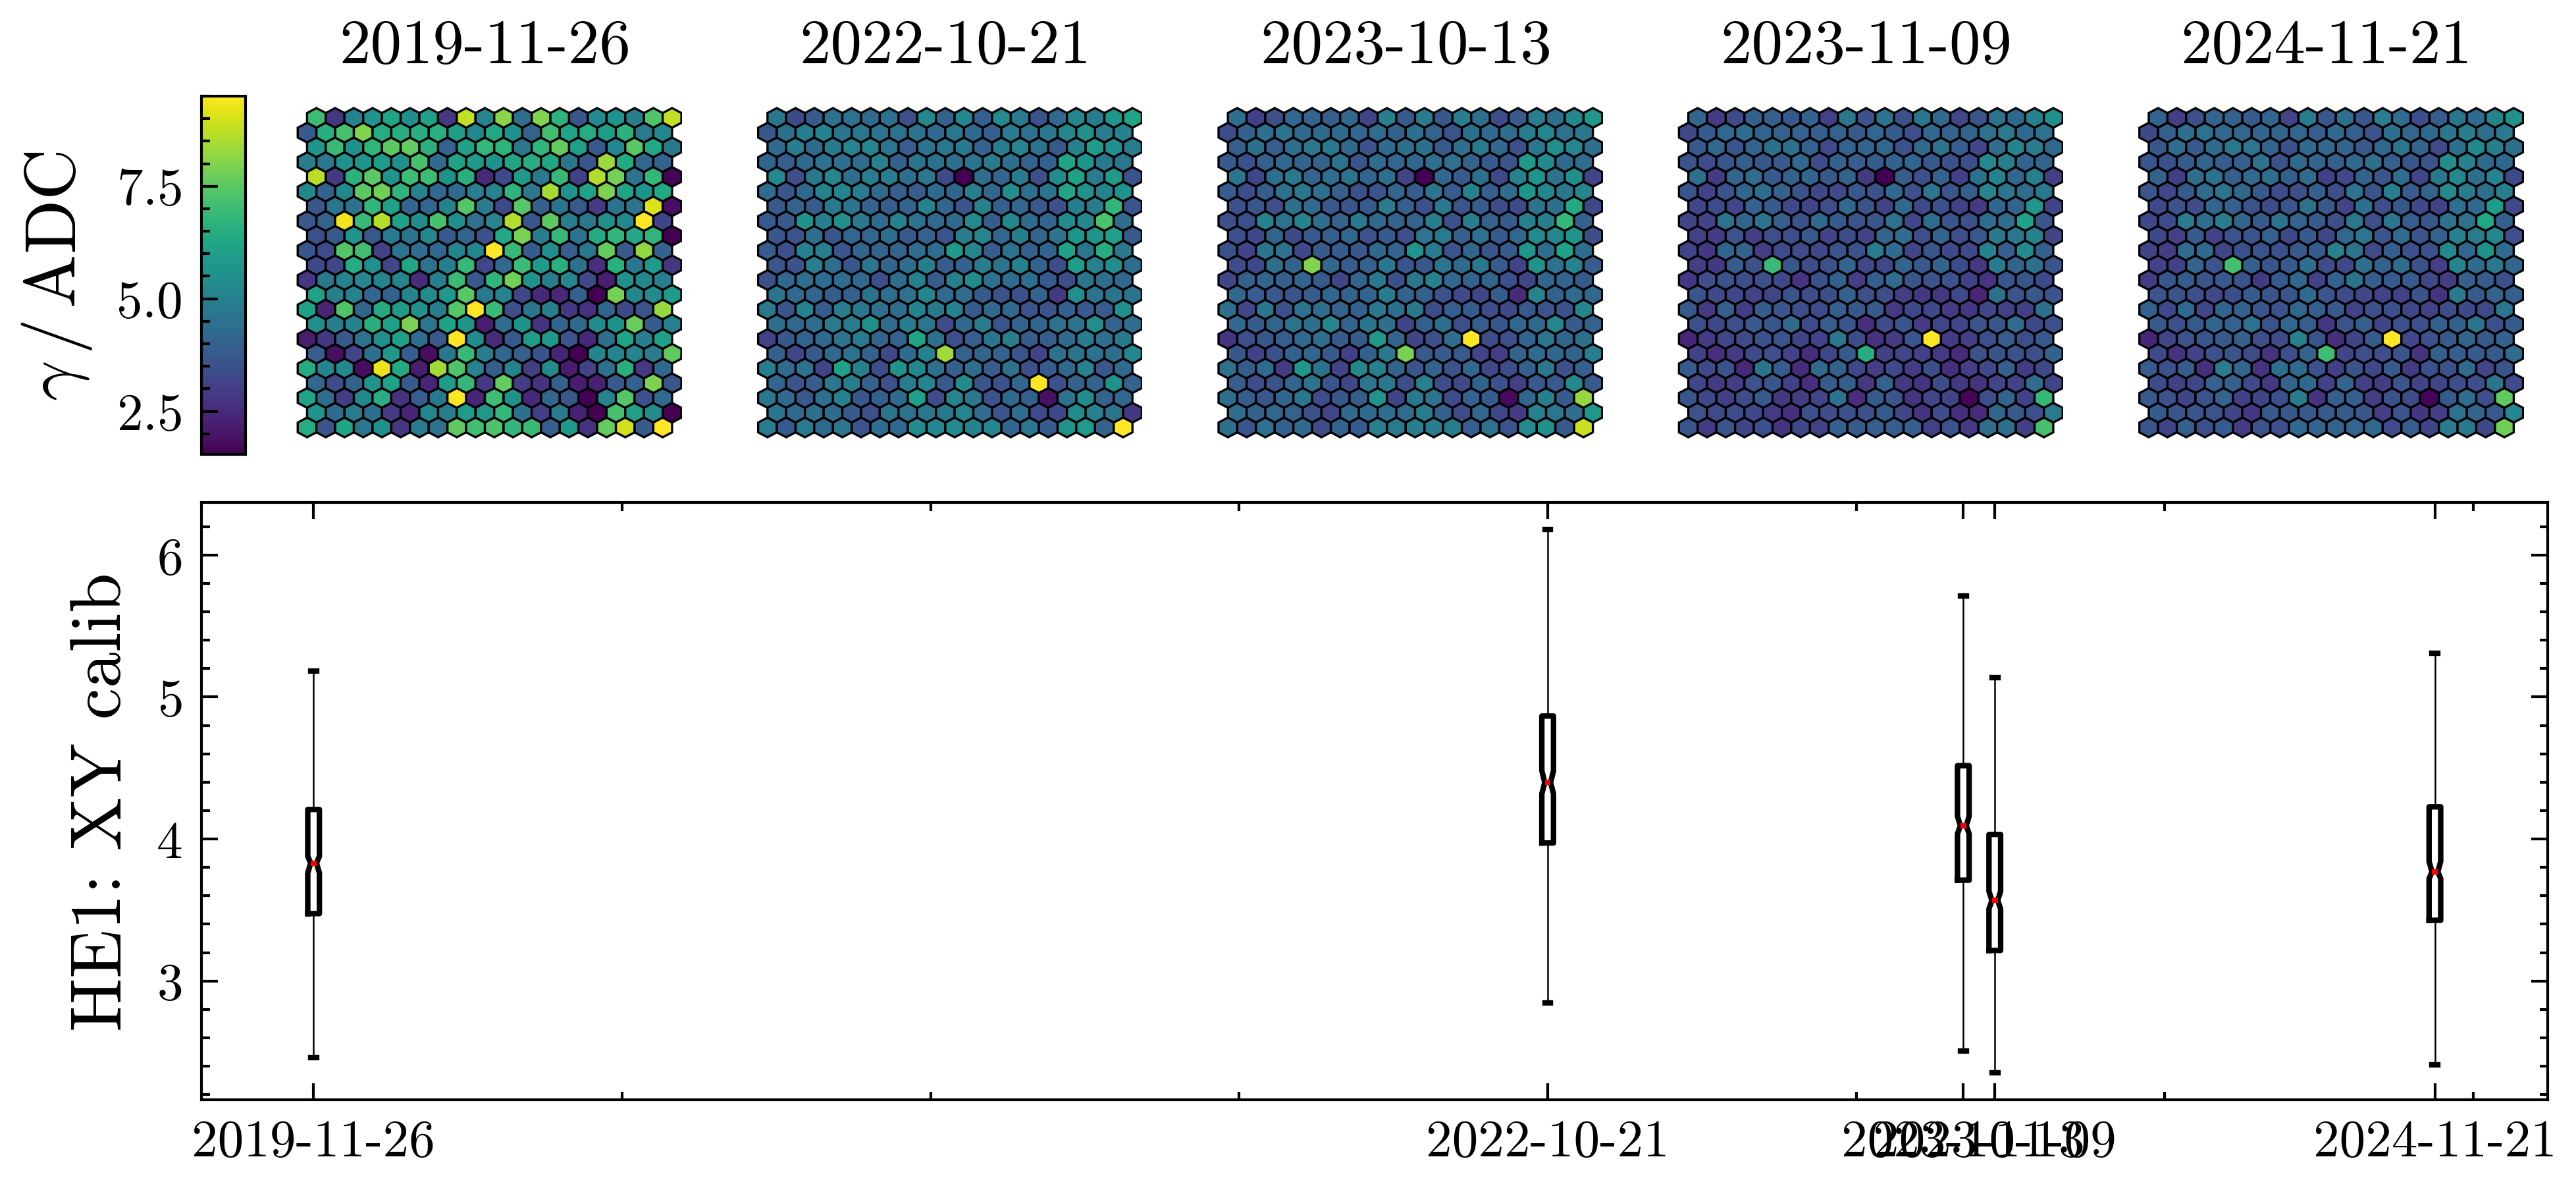

In [ ]:
test = Telescope("HE1")
test.plot_summary()

def drift_plot(self: Telescope, normalize='none', **kwargs):

    cut = lambda x: x[np.abs(x - np.mean(x)) < np.std(x)]
    print(self)

    fig = plt.figure()
    gs = GridSpec(
        2,
        len(self.runs) + 1,
        fig,
        height_ratios=[0.6, 1],
        width_ratios=[0.1] + [1 for _ in range(len(self.runs))]
    )
    gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.1)

    pixel_plots = [fig.add_subplot(gs[0, i], aspect='equal') for i in range(1, len(self.runs) + 1)]
    history_plot = fig.add_subplot(gs[1, :])
    colorbar = fig.add_subplot(gs[0, 0])

    vmin, vmax = np.inf, -np.inf
    data, positions, labels = [], [], []
    fit_y = []
    for run, ax in zip(self.runs.values(), pixel_plots):
        vmin, vmax = np.min([vmin, *cut(run.xy)]), np.max([vmax, *cut(run.xy)])
        
        if normalize == "none":
            norm = np.ones(440)
            colorbar_label = r"$\gamma\,/\,\mathrm{ADC}$"
        elif normalize == "cala":
            norm = run.cala
            colorbar_label = "XY / std."
            vmin, vmax = np.min(vmin/norm), np.max(vmax/norm)

        PixelPlot(run.xy / norm, ax, title=run.year_month_day, vmin=vmin, vmax=vmax, lw=0.4)
        data.append(run.xy / norm)
        positions.append(datetime.strptime(run.year_month_day, "%Y-%m-%d").timestamp())
        fit_y.append(np.median(run.xy / norm))
        labels.append(run.year_month_day)

    history_plot.boxplot(data, positions=positions, tick_labels=labels, widths=3600*24*10,
                         whiskerprops={'lw': 0.3}, notch=True,
                         bootstrap=5000, showfliers=False)
    
    # drift 
    # TODO

    history_plot.set_ylabel(f"{self.tel}: XY calib")
    
    ColorbarBase(
            colorbar,
            cmap=plt.cm.viridis,
            norm=colors.Normalize(vmin, vmax),
            orientation="vertical",
            label=colorbar_label
        )
    
    colorbar.yaxis.set_ticks_position('left')
    colorbar.yaxis.set_label_position('left')

# drift_plot(test)

In [ ]:
from utils.auger.fd import XYScanner

test = XYScanner.Campaign(2024, 11)
test.summary(normalize='cala')

In [ ]:
for run in test:
    print(run)

In [ ]:
print(test)

In [ ]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

fIn = "/cr/data01/filip/xy-calibration/campaign_summary/calib_runs_2024-11_OLO_results.csv"

df = pd.read_csv(fIn, comment='#', index_col=0,
                     dtype=defaultdict(lambda: str, global_pixel=int, mirror=int, 
                                       local_pixel=int, col=int, row=int))
df.columns = df.columns.str.strip()  # remove space in keys
label = fIn
label = label.replace("calib_runs_", "").replace("_results", "")

# because there may be nans in the cal_xy col
# pandas parses it as a default string, need to convert
df["cal_xy"] = df['cal_xy'].str.strip()
df["cal_xy"] = df["cal_xy"].astype(float)
df["mirror"] = df["mirror"].astype(float)

dfTelMean = df.groupby(["telescope"]).mean(numeric_only=True).reset_index()
plt.plot(dfTelMean["mirror"], dfTelMean["cal_xy"], '.', label=label)

In [ ]:
df.dtypes

In [ ]:
dfTelMean

In [ ]:
import pandas as pd
from collections import defaultdict

def load_runlist(year_month: str) -> pd.DataFrame:
    data = pd.read_csv(
        f"/cr/data01/filip/xy-calibration/config/calib_runlists/calib_runs_{year_month}.list",
        names=["id","tel","step","date","source","mA","forDB","jobfile","comment"],
        dtype=defaultdict(lambda: str, step="int", mA="float", forDB="bool"),
        index_col=0,
        comment="#",
        sep=";",
    )

    for col in ["source", "jobfile", "comment"]:
        data[col] = data[col].map(lambda x: x.strip().replace('"',''))

    return data

def get_xy_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        runlist['forDB']
        ]

def get_good_xy_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        runlist['forDB']
        & (runlist['step'] == 6)
        & (runlist['source'] == "OLO")
        & (runlist['mA'] == 15.9)
        & (runlist['comment'] == "")
        ]

def get_cal_a_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        (runlist['step'] == 0)
        & (runlist['source'] == "")
        & (runlist['mA'] == 0)
        ]

def get_cal_a_open_shutter_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        (runlist['step'] == 0)
        & (runlist['source'] == "")
        & (runlist['mA'] == 0)
        & (runlist['comment'].str.contains("open shutter"))
        ]

runlist=load_runlist('2024-11')

get_xy_runs(runlist)

In [ ]:
print(runlist['source'] == "OLO")

In [ ]:
runlist.iloc[0]['source']

In [ ]:
from utils.Auger.SD.Simulation import Simulation

In [ ]:
sim = Simulation(name='test_sim', offline='ds_forced_station_triggers', 
                 src='/cr/users/filip/Projects/SSDTriggerEfficiency/SdSimulationReconstructionUpgrade/',
                 PRIMARY='photon')

In [ ]:
# sim.run(191)

In [ ]:
sim.status()

In [ ]:
sim.process()

In [ ]:
sim.status()